# Image Deblurring - June Exam

### Dataset creation - DO NOT MODIFY

In [1]:
"""
Spring 2022
 Image Debluring - June Exam
 Course: Deep Learning
 Written by: Fatemeh Ranjbaran
"""

'\nSpring 2022\n Image Debluring - June Exam\n Course: Deep Learning\n Written by: Fatemeh Ranjbaran\n'

In [2]:
# import required libraries

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [3]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

## Load data

In [4]:
# Load data  and split it into train, test and validation

(X_train_noisy, X_train), (X_test_noisy, X_test) = getDataset() #use predefined function to load data
X_train_noisy, X_val_noisy, X_train, X_val = train_test_split(X_train_noisy, X_train) #split train data into train and validation

print("==" * 35)
print("The shape of train data with noise: {}".format(X_train_noisy.shape))
print("The shape of train data without noise: {}".format(X_train.shape))
print("--" * 32)
print("The shape of validation data with noise: {}".format(X_val_noisy.shape))
print("The shape of validation data without noise: {}".format(X_val.shape))
print("--" * 32)
print("The shape of test data with noise: {}".format(X_test_noisy.shape))
print("The shape of test data without noise: {}".format(X_test.shape))

The shape of train data with noise: (37500, 32, 32, 3)
The shape of train data without noise: (37500, 32, 32, 3)
----------------------------------------------------------------
The shape of validation data with noise: (12500, 32, 32, 3)
The shape of validation data without noise: (12500, 32, 32, 3)
----------------------------------------------------------------
The shape of test data with noise: (10000, 32, 32, 3)
The shape of test data without noise: (10000, 32, 32, 3)


## Create model

In [5]:
# Create Encoder

filters_l = [128, 256, 512] # Encoder/Decoder number of CNN layers and filters per layer

inputs = Input(shape = (32, 32, 3), name = 'encoder_input') # The inputs are 32x32 RGB images
x = inputs

for item in filters_l: #create Conv2D layers
    x = Conv2D(filters= item, kernel_size= (3, 3), strides=2, activation='relu', padding='same')(x)

shape = K.int_shape(x) # Return the shape of last Conv2D as a tuple
print(shape)
x = Flatten()(x) # Flattens the input
latent = Dense(256, name='latent_vector')(x) # A dense layer as last layer in the encoder

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

(None, 4, 4, 512)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               2097408   
                                                                 
Total params: 3,576,320
Trainable params:

In [6]:
# Create Decoder

latent_inputs = Input(shape=(256,), name='decoder_input')

x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x) 

for item in filters_l[::-1]: # Create Conv2DTranspose layers
    x = Conv2DTranspose(filters= item, kernel_size= (3, 3), strides=2, activation='relu', padding='same')(x)

outputs = Conv2DTranspose(filters=3, kernel_size= (3, 3), activation='relu', padding='same', name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 8192)              2105344   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        2359808   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      1179904   
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 128)      2950

In [7]:
# Create Autoencoder usind the encoder and decoder

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder_model') # The input and the output must have the same size (32, 32, 3)
autoencoder.summary()

Model: "autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               3576320   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         5943555   
                                                                 
Total params: 9,519,875
Trainable params: 9,519,875
Non-trainable params: 0
_________________________________________________________________


## Run model



In [8]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5,
                               verbose=1, min_lr=0.5e-6) # To reduce the learning rate if there’s no improvement in the metric

callbacks = [lr_reducer]

history = autoencoder.fit(X_train_noisy, X_train, validation_data=(X_val_noisy, X_val), epochs=32, batch_size=32, callbacks=callbacks)
autoencoder.save_weights("/content/drive/MyDrive/Image_Debluring-June_Exam.h5")


Epoch 1/32
1172/1172 [==============================] - 47s 37ms/step - loss: 0.0243 - acc: 0.5528 - val_loss: 0.0099 - val_acc: 0.6249 - lr: 0.0010
Epoch 2/32
1172/1172 [==============================] - 41s 35ms/step - loss: 0.0086 - acc: 0.6682 - val_loss: 0.0074 - val_acc: 0.6786 - lr: 0.0010
Epoch 3/32
1172/1172 [==============================] - 41s 35ms/step - loss: 0.0066 - acc: 0.7474 - val_loss: 0.0060 - val_acc: 0.7609 - lr: 0.0010
Epoch 4/32
1172/1172 [==============================] - 41s 35ms/step - loss: 0.0058 - acc: 0.7634 - val_loss: 0.0054 - val_acc: 0.7761 - lr: 0.0010
Epoch 5/32
1172/1172 [==============================] - 41s 35ms/step - loss: 0.0053 - acc: 0.7720 - val_loss: 0.0051 - val_acc: 0.7851 - lr: 0.0010
Epoch 6/32
1172/1172 [==============================] - 41s 35ms/step - loss: 0.0050 - acc: 0.7767 - val_loss: 0.0049 - val_acc: 0.7972 - lr: 0.0010
Epoch 7/32
1172/1172 [==============================] - 41s 35ms/step - loss: 0.0048 - acc: 0.7837 - val_l

## Visualization

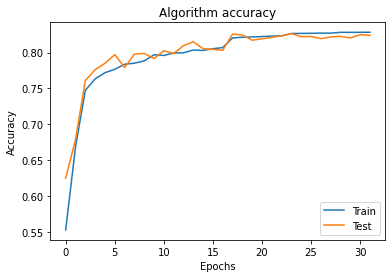

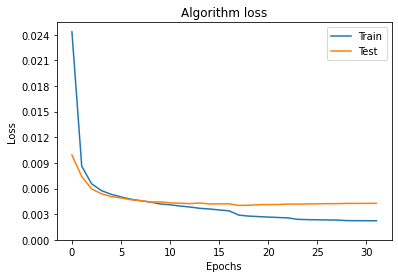

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

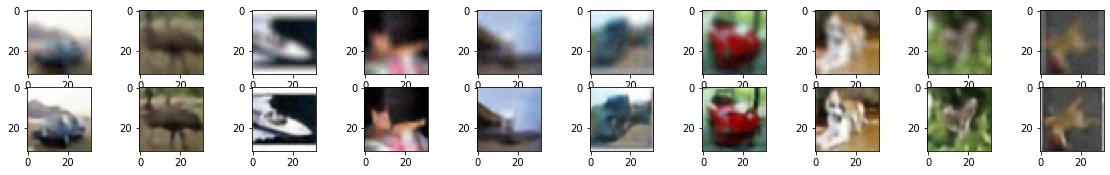

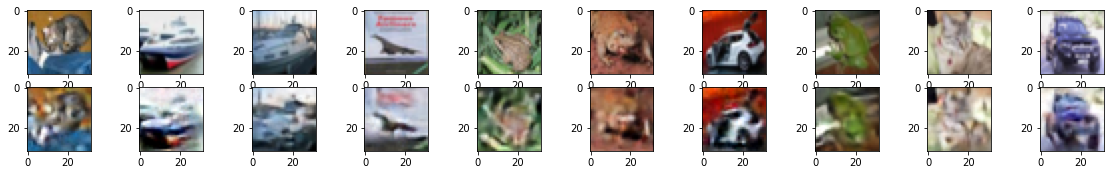

In [11]:
from matplotlib import figure
# Visualize the result of model

def visualization(H, net, X_test_noisy):
  """
  Visulize the result of model:
      H: history of model
      net: the model
      X_test_noisy: the imagees with noise
        
  """
  # Plot Accuracy
  plt.plot(H.history["acc"], label= "train accuracy")
  plt.plot(H.history["val_acc"], label="val accuracy")
  plt.legend(["Train", "Test"])
  plt.title("Algorithm accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")

  plt.show()
  
  # Plot Loss
  plt.plot(H.history["loss"], label= "train loss")
  plt.plot(H.history["val_loss"], label="val loss")
  plt.legend(["Train", "Test"])
  plt.title("Algorithm loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.yticks(np.arange(0, 0.025, 0.003))

  plt.show()

  no_noise_image = net.predict(X_test_noisy)
  predict_image = net.predict(X_test)

  plt.figure(figsize=(40, 4))

  for i in range (10):

    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test_noisy[i].reshape(32, 32, 3))

    ax = plt.subplot(3, 20, 20 + i + 1)
    plt.imshow(no_noise_image[i].reshape(32, 32, 3))
  
  plt.figure(figsize=(40, 4))

  for i in range (10):

    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))

    ax = plt.subplot(3, 20, 20 + i + 1)
    plt.imshow(predict_image[i].reshape(32, 32, 3))

  plt.show()

visualization(history, autoencoder, X_train_noisy)